In [1]:
# -*- coding: utf-8 -*-
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ""
from keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.applications.imagenet_utils import decode_predictions
import numpy as np
import cv2
from cv2 import *
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp
from scipy.misc import toimage
import sys
sys.path.append("..")
from src.network.hiarGoogLenet import hiarGoogLeNet
from src.network.GoogleLenet import GoogLeNet
from src.network.hiarBayesGoogLenet import hiarBayesGoogLeNet

low_level = [11]#,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91
mid_level = [9,10,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42]
high_level = [0,1,2,3,4,5,6,7,8,43,44,45,46,47,48,49,50]#,51,52,53,54,55,56,57,58,59,60,61,62
image_width = 120
image_height = 320
model_h = hiarGoogLeNet.build(image_height, image_width, 3, [len(low_level), len(mid_level), len(high_level)])
model_h.load_weights("/home/anhaoran/codes/pedestrian_attibutes_wpal/models/imagenet_models/hiarGoogLeNet_RAP/binary51_epoch50_valloss0.21.hdf5")
model_g = GoogLeNet.build(image_height, image_width, 3, 51)
model_g.load_weights("../models/imagenet_models/GoogLeNet_RAP/binary51_epoch50_valloss0.54.hdf5")
model_gh = hiarBayesGoogLeNet.build(image_height, image_width, 3, [len(low_level), len(mid_level), len(high_level)])
model_gh.load_weights("../models/imagenet_models/hiarBayesGoogLeNet_RAP/binary51_epoch50_valloss0.21.hdf5")

Using TensorFlow backend.


ImageNet...


In [2]:
model_g.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 320, 120, 3)  0                                            
__________________________________________________________________________________________________
conv1_7x7_s2 (Conv2D)           (None, 160, 60, 64)  9472        input_2[0][0]                    
__________________________________________________________________________________________________
conv1_7x7_s2_bn (BatchNormaliza (None, 160, 60, 64)  256         conv1_7x7_s2[0][0]               
__________________________________________________________________________________________________
max_pooling2d_14 (MaxPooling2D) (None, 80, 30, 64)   0           conv1_7x7_s2_bn[0][0]            
__________________________________________________________________________________________________
conv2_3x3 

In [3]:
model_h.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 120, 3)  0                                            
__________________________________________________________________________________________________
conv1_7x7_s2 (Conv2D)           (None, 160, 60, 64)  9472        input_1[0][0]                    
__________________________________________________________________________________________________
conv1_7x7_s2_bn (BatchNormaliza (None, 160, 60, 64)  256         conv1_7x7_s2[0][0]               
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 80, 30, 64)   0           conv1_7x7_s2_bn[0][0]            
__________________________________________________________________________________________________
conv2_3x3 

In [4]:
model_gh.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 320, 120, 3)  0                                            
__________________________________________________________________________________________________
conv1_7x7_s2 (Conv2D)           (None, 160, 60, 64)  9472        input_3[0][0]                    
__________________________________________________________________________________________________
conv1_7x7_s2_bn (BatchNormaliza (None, 160, 60, 64)  256         conv1_7x7_s2[0][0]               
__________________________________________________________________________________________________
max_pooling2d_27 (MaxPooling2D) (None, 80, 30, 64)   0           conv1_7x7_s2_bn[0][0]            
__________________________________________________________________________________________________
conv2_3x3 

(1, 320, 120, 3)


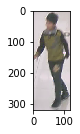

In [5]:
def load_original(img_path, img_height, img_width):
    # 把原始图片压缩为 299*299大小
    img = image.load_img(img_path, target_size=(image_height, image_width, 3))
    plt.figure(0)
    plt.subplot(211)
    plt.imshow(img)
    return img

img_path = '/home/anhaoran/data/pedestrian_attributes_RAP/RAP_dataset/CAM01_2014-02-15_20140215161032-20140215162620_tarid101_frame6541_line1.png'
img = load_original(img_path, image_height, image_width)
img_arr = image.img_to_array(img)
img_arr = np.expand_dims(img_arr, axis=0)
print(img_arr.shape)

filter_ 0


/home/anhaoran/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


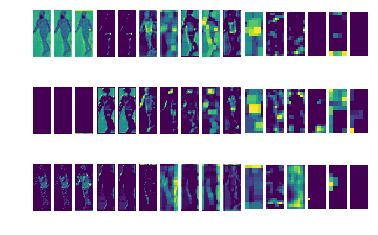

filter_ 1


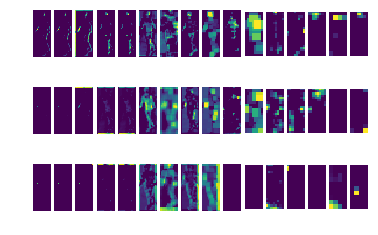

filter_ 2


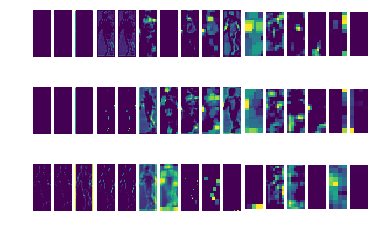

filter_ 3


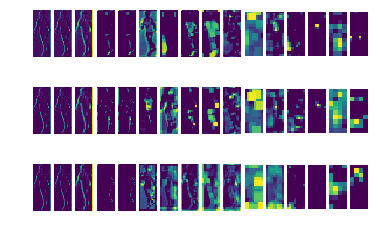

filter_ 4


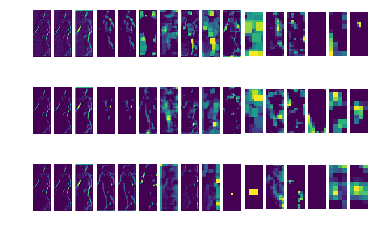

filter_ 5


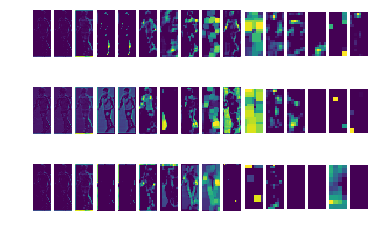

filter_ 6


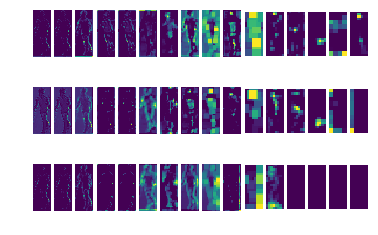

filter_ 7


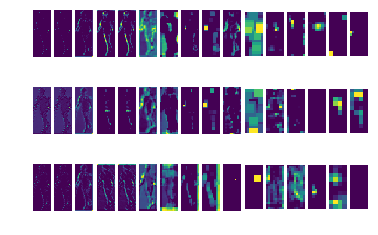

filter_ 8


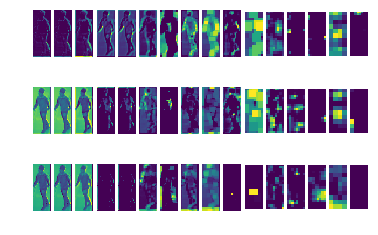

filter_ 9


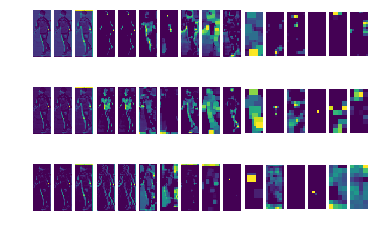

filter_ 10


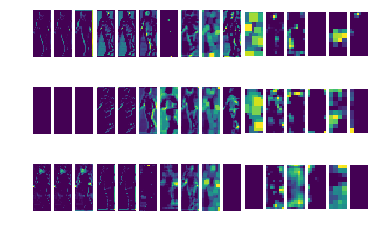

filter_ 11


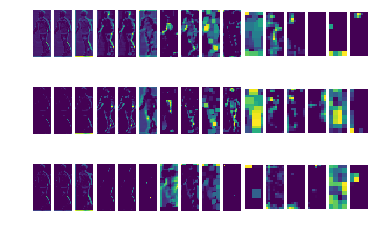

filter_ 12


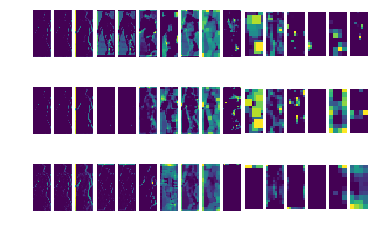

filter_ 13


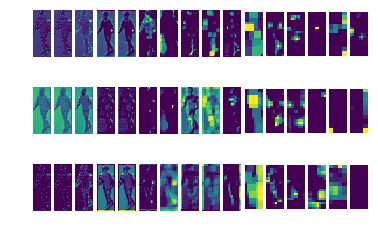

filter_ 14


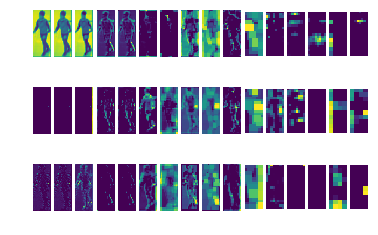

filter_ 15


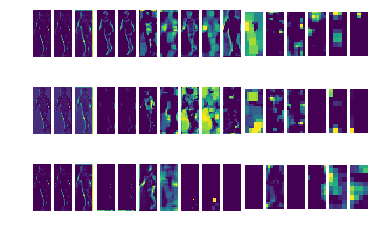

filter_ 16


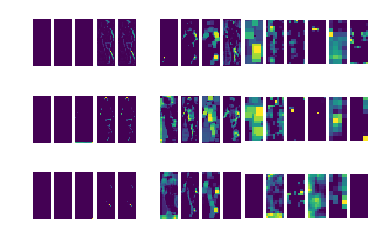

filter_ 17
layer number error. 16 , 17


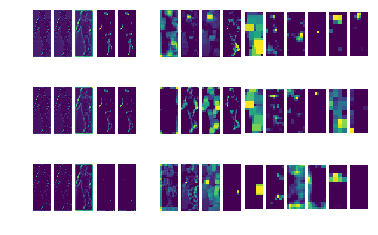

filter_ 18
layer number error. 16 , 18


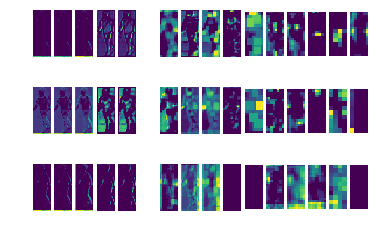

filter_ 19
layer number error. 16 , 19


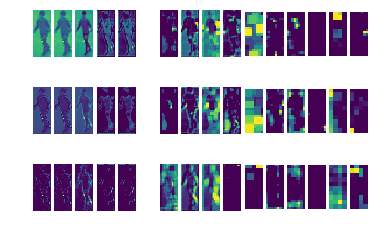

In [8]:
def extract_features_one_layer_allmodels(model, x, filter_id, layer_id, layer_num_list):
    '''
    提取指定模型指定层指定数目的feature map并输出到一幅图上.
    :param ins: 模型实例
    if len(ins) != 2:
        print('parameter error:(model, instance)')
        return None
    :param layer_id: 提取指定层特征
    :param filters: 每层提取的feature map数
    :param layer_num_list: 一共提取多少层feature map
    :return: None
    '''
    for i in range(len(model)):
        if type(layer_id) == type(1):
            model_extractfeatures = Model(inputs=model[i].input, outputs=model[i].get_layer(index=layer_id).output)
        else:
            model_extractfeatures = Model(inputs=model[i].input, outputs=model[i].get_layer(name=layer_id).output)
        #model_extractfeatures.summary()
        fc2_features = model_extractfeatures.predict(x)
        if filter_id > len(fc2_features[0][0][0]):
            print('layer number error.', len(fc2_features[0][0][0]),',',filter_id)
            return None
        #plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
        plt.subplot(len(model), len(layer_num_list), layer_num_list.index(layer_id) + 1 + i * len(layer_num_list) )
        plt.axis("off")
        if filter_id < len(fc2_features[0][0][0]):
            plt.imshow(fc2_features[0, :, :, filter_id])
            plt.savefig("../results/1.jpg", dpi=250, quality=95)

# 层数、模型、卷积核数
def extract_features_batch_layer_allmodels(model, x, filter_id, layer_num_list, path):
    '''
    批量提取特征
    :param layer_num: 层数
    :param model: 模型
    :param filters: feature map数
    :return: None
    '''
    #plt.figure(figsize=(filters, layer_num))
    plt.subplot(len(model), len(layer_num_list), 1)
    for i in layer_num_list:
        extract_features_one_layer_allmodels(model, x,filter_id, i, layer_num_list)
    plt.savefig(path, dpi=250, quality=95)
    plt.show()
    
for i in range(20):
    print("filter_", str(i))
    extract_features_batch_layer_allmodels([model_gh, model_h, model_g], 
                                           img_arr, i, 
                                           [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 70, 90, 110, 130], 
                                           '../results/samples/RAP_sample_all_model_filter'+str(i)+'.jpg')

/home/anhaoran/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


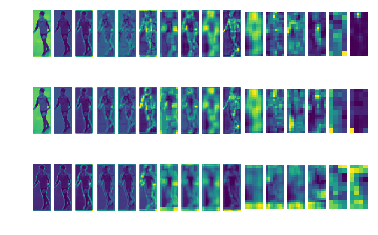

In [18]:
def extract_features_merge_one_layer_allmodels(model, x, layer_id, layer_num_list):
    '''
    提取指定模型指定层指定数目的feature map并输出到一幅图上.
    :param ins: 模型实例
    if len(ins) != 2:
        print('parameter error:(model, instance)')
        return None
    :param layer_id: 提取指定层特征
    :param filters: 每层提取的feature map数
    :param layer_num_list: 一共提取多少层feature map
    :return: None
    '''
    for i in range(len(model)):
        if type(layer_id) == type(1):
            model_extractfeatures = Model(inputs=model[i].input, outputs=model[i].get_layer(index=layer_id).output)
        else:
            model_extractfeatures = Model(inputs=model[i].input, outputs=model[i].get_layer(name=layer_id).output)
        #model_extractfeatures.summary()
        fc2_features = model_extractfeatures.predict(x)
        #plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
        plt.subplot(len(model), len(layer_num_list), layer_num_list.index(layer_id) + 1 + i * len(layer_num_list) )
        plt.axis("off")
        feature_map_combination = []
        for i in range(fc2_features.shape[3]):
            feature_map_combination.append(fc2_features[0, :, :, i])
        feature_map_sum = sum(ele for ele in feature_map_combination)
        #print(feature_map_sum.shape)
        plt.imshow(feature_map_sum)
        #plt.savefig("../results/1.jpg", dpi=250, quality=95)

# 层数、模型、卷积核数
def extract_features_merge_batch_layer_allmodels(model, x, layer_num_list, path):
    '''
    批量提取特征
    :param layer_num: 层数
    :param model: 模型
    :param filters: feature map数
    :return: None
    '''
    #plt.figure(figsize=(filters, layer_num))
    plt.subplot(len(model), len(layer_num_list), 1)
    for i in layer_num_list:
        extract_features_merge_one_layer_allmodels(model, x, i, layer_num_list)
    plt.savefig(path, dpi=250, quality=95)
    plt.show()
    
extract_features_merge_batch_layer_allmodels([model_gh, model_h, model_g], 
                                           img_arr,
                                           [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 70, 90, 110, 130], 
                                           '../results/samples/RAP_sample_all_model_merge.jpg')

In [9]:
weights = model_gh.get_layer('high_cond').get_weights()
print(weights)
print(weights[0].shape)

[array([[-5.95039725e-02,  5.89385927e-01,  6.69705808e-01,
         3.86584491e-01, -1.10289874e-03,  4.88027334e-01,
         1.96745798e-01,  1.79485857e+00, -1.33018583e-01,
        -5.18244109e-04, -1.64421692e-01,  1.96158499e-01,
        -1.69705629e-01, -1.19261838e-01, -6.82466567e-01,
        -4.31064159e-01, -1.56323925e-01],
       [-1.46096015e+00, -3.96164984e-01, -2.00779366e+00,
         2.59380460e+00,  1.07456410e+00, -8.74463677e-01,
        -1.13777816e+00,  1.01889300e+00, -7.28447139e-01,
         9.46112946e-02, -1.81195199e+00, -1.17669618e+00,
         3.22177708e-01, -2.44258940e-02, -7.67447352e-02,
        -9.93077099e-01, -9.51249063e-01],
       [ 4.57204151e+00,  1.37603179e-01,  6.22094154e-01,
        -1.98803559e-01,  1.59818277e-01,  2.48416245e-01,
        -1.34353518e-01,  5.04192352e-01,  1.03121078e+00,
        -4.42387193e-01,  2.58575290e-01, -1.65307105e-01,
         1.43643051e-01, -1.71347037e-01,  1.57846794e-01,
        -2.10310340e-01, -4.

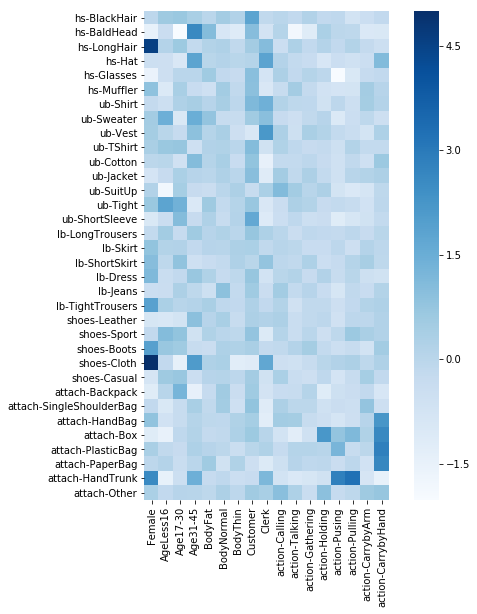

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.subplots(figsize=(9, 9))
sns.heatmap(weights[0], cmap="Blues", square=True, 
            yticklabels = ['hs-BlackHair', 'hs-BaldHead', 'hs-LongHair', 'hs-Hat', 'hs-Glasses', 'hs-Muffler', 'ub-Shirt', 'ub-Sweater', 'ub-Vest', 'ub-TShirt', 'ub-Cotton', 'ub-Jacket', 'ub-SuitUp', 'ub-Tight', 'ub-ShortSleeve', 'lb-LongTrousers', 'lb-Skirt', 'lb-ShortSkirt', 'lb-Dress', 'lb-Jeans', 'lb-TightTrousers', 'shoes-Leather', 'shoes-Sport', 'shoes-Boots', 'shoes-Cloth', 'shoes-Casual', 'attach-Backpack', 'attach-SingleShoulderBag', 'attach-HandBag', 'attach-Box', 'attach-PlasticBag', 'attach-PaperBag', 'attach-HandTrunk', 'attach-Other'], 
            xticklabels = ['Female', 'AgeLess16', 'Age17-30', 'Age31-45', 'BodyFat', 'BodyNormal', 'BodyThin', 'Customer', 'Clerk', 'action-Calling', 'action-Talking', 'action-Gathering', 'action-Holding', 'action-Pusing', 'action-Pulling', 'action-CarrybyArm', 'action-CarrybyHand'])
plt.show()